# 1. Постановка задачи
В рамках данной лабораторной работы необходимо реализовать метод sv-кластеризации и проверить его работу на хорошо и плохо отделимых модельных данных.

## План работы:
1. Подготовка модельных данных
2. Реализация SVC-алгоритма
3. Кластеризация с разными значениями гиперпараметров. Оценка качества и выбор оптимальных значений гиперпараметров.
4. Графическая иллюстрация результатов, таблицы.

# 2. Алгоритм SVC-кластеризации
Алгоритм SVC-кластеризации включает в себя следующие шаги:
1. Построение ядерной матрицы: $K = \{k_{ij}\}, i, j = 1, ..., n$
$$k_{ij} = k(x_i, x_j) = exp(-q ||x_i - x_j||^2)$$
2. Решение задачи квадратичного программирования. Необходимо найти множители Лагранжа $\mu_i, i = 1, \dots, n$. Любые множители меньше $10^{−3}$ будем считать нулем. $$ \max\limits_{\mu_i} W $$ $$ W = \sum\limits_{i=1}^n \mu_i k(x_i, x_i) - \sum\limits_{i=1}^n \sum\limits_{j=1}^n k(x_i, x_j)$$ $$\sum\limits_{i=1}^n \mu_i = 1$$ $$0 \leq \mu_i \leq C, i = 1, \dots, n$$
3. Классификация векторов:
* Связанные опорные вектора (BSVs): $\mu_i = C$ лежат вне гиперсферы
* Опорные вектора (SVs): $0 < \mu_i < C$ лежат на поверхности гиперсферы.
* Другие векторы (OVs): $\mu_i = 0$ - внутри гиперсферы или на поверхности
4. Расстояние от центра гиперсферы до вектора x и радиусы гиперсфер: $$r^2(x) = k(x,x) - 2\sum\limits_{i=1}^n \mu_i k(x_i, x) + \sum\limits_{i=1}^n \sum\limits_{j=1}^n \mu_i \mu_j k(x_i, x_j)$$ $$R = r(x_i), x_i \in SVs$$
5. Маркировка кластеров. Необходимо построить матрицу смежности A. $$
A_{ij} =  \begin{cases}
   1 &\text{, если $r(y) \leq R, \forall y \in [x_i, x_j]$}\\
   0 &\text{, иначе}
 \end{cases}
$$
6. Находим кластеры как связанные компоненты графа, индуцированного матрицей A. Связанные опорные векторы не кластеризуются и впоследствии относятся к кластерам с ближайшим к ним центром.

# 3. Критерии оценки качества кластеризации

Для оценки воспользуемся критерием Калининского-Харабаша:
$$CH(C) = \frac{N-K}{K-1} \frac{\sum\limits_{C_k \in C}|C_k|\rho(\overline{C_k}, \overline{X})}{\sum\limits_{C_k \in C} \sum\limits_{x_i \in C_k} \rho(x_i, \overline{C_k})}$$
где $N$ - размер кластеризуемой выборки, $K$ - количество кластеров, $|C_k|$ - количество элементов в кластере $C_k$, $\overline{C_k}$ - центр кластера $C_k$
$$\overline{C_k} = \frac{\sum\limits_{x_i \in C_k} x_i}{|C_k|}$$
$\overline{X}$ - выборочное среднее всех исходных данных
$$\overline{X} = \frac{1}{N}\sum\limits_{x_i \in X} x_i$$
Чем больше значение критерия, тем лучше качество кластеризации.

# 4. Код
### Код SVC алгоритма и оценки качества:

In [55]:
from matplotlib import pyplot
import pandas as pd
import numpy as np
import cvxopt


class SVC:
    zero_mu = 1e-3

    @staticmethod
    def init_clustering(sample, p, q):
        svc = SVC(sample, p, q)
        svc.__find_kernel_matrix()
        svc.__find_mu()
        svc.__find_segment_matrix()
        svc.__find_clusters()
        return svc

    def show_plot(self, max_clusters_count=10):
        labels = [] #np.zeros(self.sample.shape[0])
        for i in self.clusters.keys():
            for j in self.clusters[i]:
                labels.insert(j, int(i))
        for bsv in self.bsvs:
            labels.insert(bsv, 'bsvs')

        if len(self.clusters) >= max_clusters_count:
            print("Number of clusters is more or equals 10, so no graphic")
            return
        df = pd.DataFrame(dict(x=self.sample[:, 0], y=self.sample[:, 1], label=labels))
        colors = {1: 'r', 2: 'b', 3: 'g', 4: 'c', 5: 'm', 6: 'y', 7: 'k', 8: 'b', 9: 'c'}
        fig, ax = pyplot.subplots()
        grouped = df.groupby('label')
        for key, group in grouped:
            if key == 'bsvs':
                group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, marker='s', color='slategray')
            else:
                group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])

        # Помечаем звездочками опорные вектора
        svs_val_x = [self.sample[i][0] for i in self.svs]
        svs_val_y = [self.sample[i][1] for i in self.svs]
        ax.scatter(x=svs_val_x, y=svs_val_y, marker='*', color='black')

        # # Помечаем кваратми связанные опорные вектора
        # svs_val_x = [self.sample[i][0] for i in self.bsvs]
        # svs_val_y = [self.sample[i][1] for i in self.bsvs]
        # ax.scatter(x=svs_val_x, y=svs_val_y, marker='s', color='slategray')

        pyplot.show()

    def calinski_harabasz(self):
        # K - количество кластеров
        k = len(self.clusters)
        if k == 1:
            return '-'
        if k == self.N:
            return 0

        # X - выборочное среднее всех исходных данных
        x_mean = sum(self.sample) / self.N
        scale = (self.N - k) / (k - 1)

        numerator = 0
        denominator = 0

        for cluster_num in self.clusters:
            cluster = self.clusters[cluster_num]
            # |C_k| - количество элементов в кластере
            cluster_len = len(cluster)

            cluster_sum = 0
            for id in cluster:
                cluster_sum += self.sample[id]

            # \overline{C_k} - центр кластера C_k
            cluster_center = cluster_sum / cluster_len
            numerator += cluster_len * SVC.rho(cluster_center, x_mean)

            # Считаем сумму расстояний до центра кластера
            cluster_distance_sum = 0
            for id in cluster:
                cluster_distance_sum += SVC.rho(cluster_center, self.sample[id])

            denominator += cluster_distance_sum

        return scale * numerator / denominator

    # Don't use constructor, use init_clustering
    # sample - выборка, которую кластеризуем
    def __init__(self, sample, p, q):
        self.sample = sample
        self.N = len(sample)
        self.p = p
        self.q = q
        self.C = 1 / (self.N * p)

        # Ядерная матрица
        self.km = None
        # Вектор множителей Лагранжа \mu
        self.mu = None
        # Матрица смежности A
        self.segment_matrix = None
        self.clusters = None
        self.svs = None
        self.bsvs = None

    # Инициализация ядерной матрицы
    def __find_kernel_matrix(self):
        self.km = np.zeros((self.N, self.N))
        for i in range(self.N):
            for j in range(self.N):
                self.km[i, j] = self.__kernel(self.sample[i], self.sample[j])

    # Инициализируем множители Лагранжа \mu_i
    def __find_mu(self):
        P = cvxopt.matrix(self.km)
        q = cvxopt.matrix(self.km.diagonal().reshape(self.N, 1))
        G1 = cvxopt.spmatrix(-1, range(self.N), range(self.N))
        G2 = cvxopt.spmatrix(1, range(self.N), range(self.N))
        G = cvxopt.sparse([G1, G2])
        h1 = np.zeros(self.N)
        h2 = np.full(self.N, self.C)
        h = cvxopt.matrix(np.concatenate((h1, h2), axis=0), (2 * self.N, 1))
        A = cvxopt.matrix(1.0, (1, self.N))
        b = cvxopt.matrix(1.0)
        cvxopt.solvers.options['show_progress'] = False
        sol = cvxopt.solvers.qp(P, q, G, h, A, b)
        self.mu = np.array(sol['x'])

    def __find_segment_matrix(self):
        svs_tmp = np.array(self.C > self.mu + SVC.zero_mu) * np.array(self.mu > SVC.zero_mu)
        self.svs = np.where(svs_tmp == True)[0]
        bsvs_tmp = np.array(np.isclose(self.mu, self.C, atol=SVC.zero_mu))
        self.bsvs = np.where(bsvs_tmp == True)[0]
        r = np.mean([self.__r2_func(self.sample[i]) for i in self.svs[:5]])
        self.segment_matrix = np.zeros((self.N, self.N))
        for i in range(self.N):
            if i not in self.bsvs:
                for j in range(i, self.N):
                    if j not in self.bsvs:
                        self.segment_matrix[i, j] = self.segment_matrix[j, i] = self.__segment(self.sample[i],
                                                                                               self.sample[j], r)

    def __find_clusters(self):
        ids = list(range(self.N))
        for el in self.bsvs:
            ids.remove(el)
        self.clusters = {}
        num_clusters = 0
        while ids:
            num_clusters += 1
            self.clusters[num_clusters] = []
            curr_id = ids.pop(0)
            queue = [curr_id]
            while queue:
                cid = queue.pop(0)
                for i in ids:
                    if self.segment_matrix[i, cid]:
                        queue.append(i)
                        ids.remove(i)
                self.clusters[num_clusters].append(cid)

    def __r2_func(self, x):
        return 1 - 2 * sum(
            self.mu[i] * self.__kernel(self.sample[i], x) for i in range(self.N)
        )

    def __kernel(self, x1, x2):
        return np.exp(-self.q * sum((x1 - x2) ** 2))

    # Вычисление элемента матрицы смежности A_ij
    def __segment(self, x1, x2, r, n=10):
        for i in range(n):
            x = x1 + (x2 - x1) * i / (n + 1)
            if self.__r2_func(x) > r:
                return False
        return True

    # Расстояние между 2мя точками
    @staticmethod
    def rho(x1, x2):
        return np.linalg.norm(x1 - x2)

### Код для формирования хорошо и плохо отделимых данных:

In [2]:
from scipy.stats import multivariate_normal


def get_sample(n, s):
    m1 = np.array([2, 1])
    m2 = np.array([0, 13])
    m3 = np.array([15, 8])
    size = int(n / 3)
    cluster1 = multivariate_normal(mean=m1, cov=s).rvs(size)
    cluster2 = multivariate_normal(mean=m2, cov=s).rvs(size)
    if n % 3 != 0:
        size += 1
    cluster3 = multivariate_normal(mean=m3, cov=s).rvs(size)

    pyplot.scatter(x=cluster1[:, 0], y=cluster1[:, 1], color='r')
    pyplot.scatter(x=cluster2[:, 0], y=cluster2[:, 1], color='g')
    pyplot.scatter(x=cluster3[:, 0], y=cluster3[:, 1], color='b')
    pyplot.show()

    return np.vstack([cluster1, cluster2, cluster3])


n = 100
s_good = np.array([[2, 0],
                   [0, 2]])
s_bad = s_good * 5

### Код для исследования качества кластеризации и построения итоговой таблицы:

In [109]:
def research(sample, max_cluster_count=10):
    max = np.max([sum((sample[i] - sample[j]) ** 2) for i in range(len(sample)) for j in range(len(sample))])
    q1 = 1 / max
    print(f"q1 = {q1}")

    pq_set = (
        # (0.01, q1),
        # (0.01, 0.01),
        # (0.01, 0.015),
        # (0.01, 0.02),
        # (0.1, 0.03),
        # (0.1, 0.04),
        # (0.1, 0.05),
        # (0.1, 0.065),
        # (0.1, 0.08),
        # (0.1, 0.085),
        # (0.2, 0.085),
        (0.25, 0.085),
        (0.3, 0.085),
        (0.35, 0.085),

        (0.4, 0.085),
        (0.5, 0.085),
        # (0.1, 0.1),
        # (0.15, 0.07),
        # (0.16, 0.07),
        # (0.17, 0.07),
        # (0.18, 0.08),
        # (0.19, 0.07),
        # (0.191, 0.07),
        # (0.192, 0.07),
        # (0.193, 0.07),
        # (0.195, 0.07),

        # (0.2, 0.07),
        # (0.25, 0.07),
        # (0.01, 0.075),
        # (0.01, 0.08),
        # (0.01, 0.1),
        # (0.1, 0.1),
        # (0.2, 0.1),
        # (0.1, 0.3),
        # (0.3, 0.3)
    )

    table = pd.DataFrame(columns=['p', 'q', 'clusters count', 'SVs', 'BSVs', 'CH'])
    for pq in pq_set:
        svc = SVC.init_clustering(sample, p=pq[0], q=pq[1])
        ch = svc.calinski_harabasz()

        print("p, q, clusters count, SVs, BSVs, CH")
        row = [pq[0], pq[1], len(svc.clusters), len(svc.svs), len(svc.bsvs), ch]
        print(row)
        table.loc[len(table)] = row

        svc.show_plot(max_cluster_count)

    return table


In [111]:
%%html
<style>
.output_wrapper .output {
  overflow-y: visible;
  height: fit-content;
}
</style>

# 5. Хорошо отделимые данные
Посмотрим как работает наш алгоритм на хорошо отделимых данных, возьмем 100 точек в 3х разных кластерах

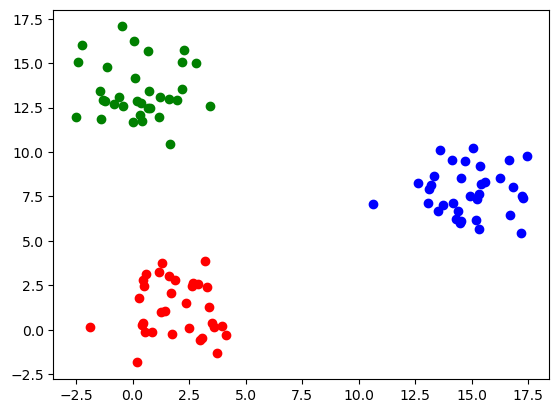

In [39]:
good_sample = get_sample(100, s_good)

Построим графики полученной алгоритмом кластеризации для разных параметров p и q и сравним их в итоговой таблице. Графики, на которых больше 10 кластеров, выводить не будем.
Звездочками отвечены опорные вектора, а квадратами связанные опорные вектора.

q1 = 0.0020449272153024137
p, q, clusters count, SVs, BSVs, CH
[0.01, 0.01, 2, 10, 0, 126.79265356019157]


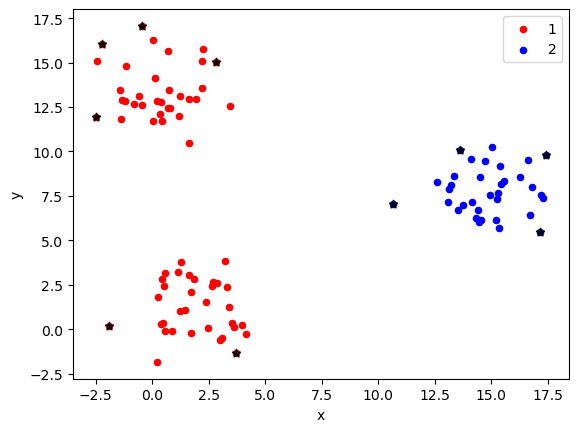

p, q, clusters count, SVs, BSVs, CH
[0.1, 0.07, 4, 18, 1, 143.9703472646575]


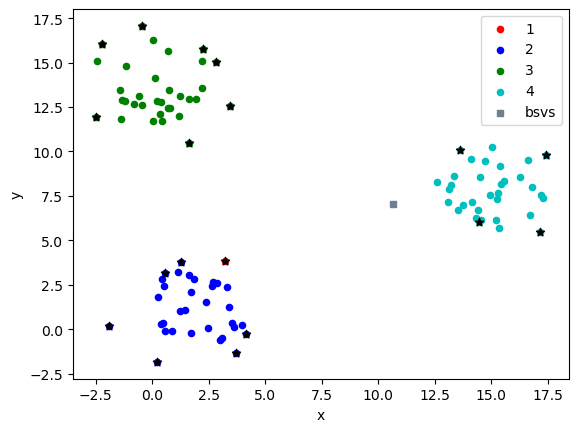

KeyboardInterrupt: 

In [72]:
good_sample_table = research(good_sample)

Итоговая таблица:

In [53]:
good_sample_table

NameError: name 'good_sample_table' is not defined

Дающими хороший результат стали пары p и q: [0.01, 0.03], [0.01, 0.1] и [0.1, 0.1], однако пара [0.01, 0.03] дает наименьшее количество опорных векторов, поэтому ее можно назвать наилучшей, вектора из этой пары хорошо делят пространство признаков.

# 6. Плохо отделимые данные
Посмотрим как ведет себя алгоритм при работе с плохо отделимыми данными. Графики построим только для тех случаев, где меньше 20 кластеров.

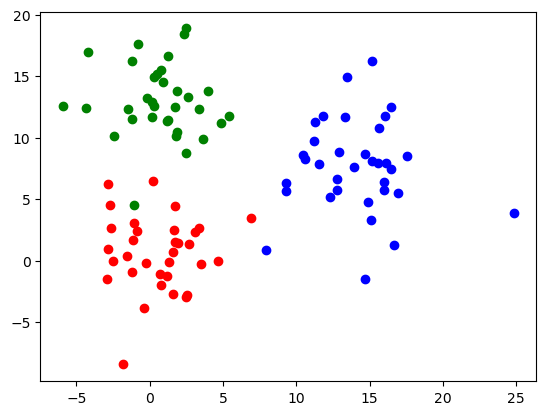

In [103]:
bad_sample = get_sample(100, s_bad)

q1 = 0.0009794375871597957
p, q, clusters count, SVs, BSVs, CH
[0.25, 0.085, 2, 33, 8, 101.7966586126122]


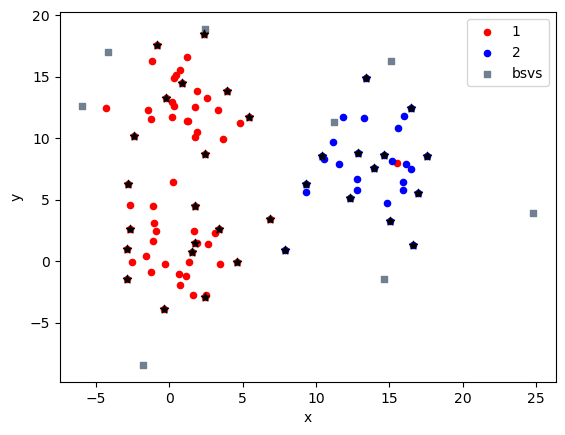

p, q, clusters count, SVs, BSVs, CH
[0.3, 0.085, 5, 30, 17, 65.28558212855133]


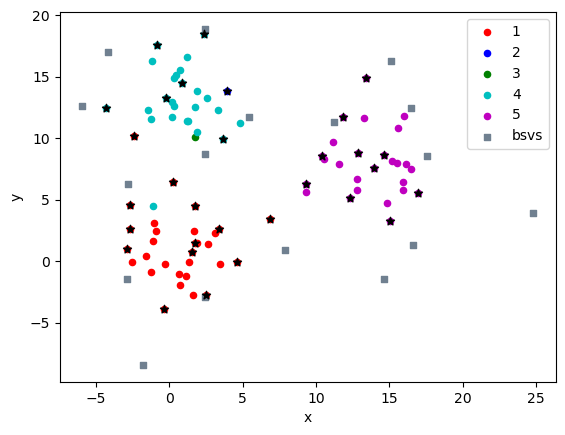

p, q, clusters count, SVs, BSVs, CH
[0.35, 0.085, 6, 23, 25, 55.461256247883014]


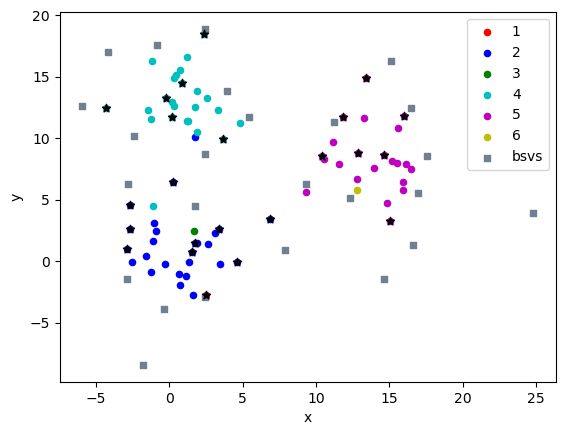

p, q, clusters count, SVs, BSVs, CH
[0.4, 0.085, 7, 23, 30, 53.80503746982]


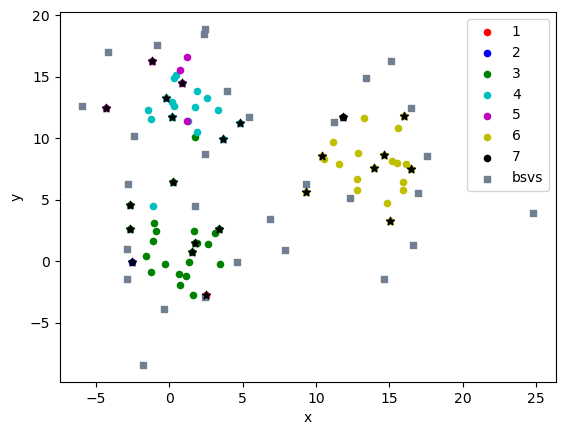

p, q, clusters count, SVs, BSVs, CH
[0.5, 0.085, 7, 22, 42, 60.29745329942652]


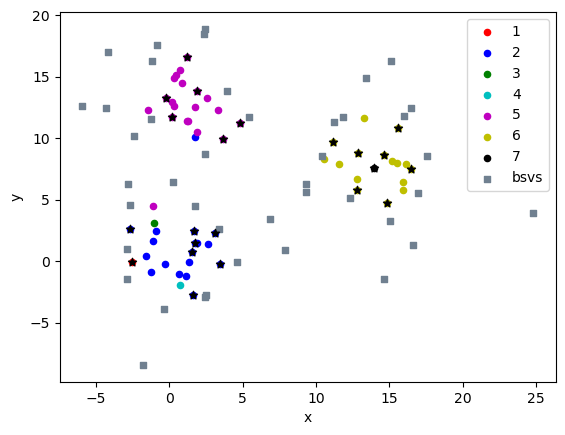

In [110]:
bad_sample_table = research(bad_sample)

Итоговая таблица:

In [113]:
bad_sample_table

,p,q,clusters count,SVs,BSVs,CH
0,0.25,0.085,2.0,33.0,8.0,101.796659
1,0.30,0.085,5.0,30.0,17.0,65.285582
2,0.35,0.085,6.0,23.0,25.0,55.461256
3,0.40,0.085,7.0,23.0,30.0,53.805037
4,0.50,0.085,7.0,22.0,42.0,60.297453


# 7. Выводы
* Был рассмотрен и реализован SVC-алгоритм кластеризации
* Протестировали работу алгоритма на хорошо и плохо отделимых данных
* Сравнили качество работы алгоритма с разными гиперпараметрами с помощью критерия Калининского-Харабаша
* На хорошо отделимых данных алгоритм работает лучше
* Для хорошо отделимых данных оптимальными гиперпараметрами, дающими хороший результат стали пары p и q: [0.01, 0.03], [0.01, 0.1] и [0.1, 0.1], однако пара [0.01, 0.03] дает наименьшее количество опорных векторов, поэтому ее можно назвать наилучшей, вектора из этой пары хорошо делят пространство признаков.
* Для плохо отделимых данных наилучшими гиперпарметрами стали p = 0.3, q = 0.3, также можно отметить пару [0.1, 0.1], ее качество разбиения не сильно хуже, но опорных векторов существенно меньше.
* Начиная с какого-то момента, при увеличении гиперпараметров падает качество кластеризации и растет количество связанных опорных векторов
* Также было замечено, что при наличии связанных опорных векторов кластеризация не дает хорошие результаты, такие резултаты кластеризации могут быть связаны с довольно сложной границей между кластерами